In [1]:
# Descomente para executar no colab
#! pip install git+https://github.com/flaviovdf/musica.git

# Music Auto Tagging (Multi-Label Classification and Metric Learning Approach)


Music auto-tagging is an important task that can be used in many musical applications such as music search or recommender systems. 

Two central methods for representation learning include deep metric learning and classification, both having the same goal of learning a representation that can generalize well across tasks.

Your mission is to build your own Neural Network model to represent audio signal. Specifically, the goals of this homework are as follows:

* Experiencing the whole pipeline of deep learning based system: data preparation, feature extraction, model training and evaluation
* Getting familiar with the Neural Network architectures for music representation
* Using Pytorch in practice

# Getting Ready

## Preparing The Dataset
We use the [magnatagatune](https://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset) dataset which has been the most widely used in the music tagging task.  The MagnaTagATune dataset consists of 25k music
clips from 6,622 unique songs.

The dataset contains 30-second audio files including 189 different tags
For this homework, we are going to use a magnatagatune with 8-second audio and only 50 genres.

We use subset of magnatagatune dataset (9074 samples x 8 sec).

To make your life easier, place them in a directory as below:

```
├── annotations_final.csv
├── waveform
  ├── 1
  ├── ...
  └── d
```

## Importing Packages

In [2]:
from μsica import μsf
from μsica import μsp

from glob import glob

import flax.linen as nn
import jax.numpy as jnp
import jax

import librosa
import matplotlib.pyplot as plt
import numpy as np
import optax
import os
import pandas as pd

In [3]:
# Descomente para baixar novamente
#μsf.download('https://dcc.ufmg.br/~flaviovdf/mir/lab07/files.zip', 'files.zip',False)
#μsf.extract('files.zip', '.')

In [4]:
μsp.init_matplotlib()
plt.ion()

## Enabling and testing the GPU

First, you'll need to enable GPUs for the Colab notebook:

- Navigate to Edit (수정) → Notebook Settings (노트 설정)
- select GPU from the Hardware Accelerator (하드웨어 가속기) drop-down

Next, we'll confirm that we can connect to the GPU with PyTorch and check versions of packages:

If the cell above throws an error, then you should enable the GPU following the instruction above!

# Data Checking


In [5]:
df = pd.read_csv('subset_magnatune.csv', index_col=0)
df.shape

(1048, 189)

In [6]:
df.head()

,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,clasical,...,rap,metal,hip hop,quick,water,baroque,women,fiddle,english,mp3_path
clip_id,,,,,,,,,,,,,,,,,,,,,
29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0/american_bach_soloists-j_s__bach__cantatas_v...
105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0/rocket_city_riot-last_of_the_pleasure_seeker...
293,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/strojovna_07-number_1-01-ambi_crack-59-88.npy
294,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/strojovna_07-number_1-01-ambi_crack-88-117.npy
303,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1/ambient_teknology-phoenix-01-ambient_teknolo...


[Text(0, 0.5, 'Frequência')]

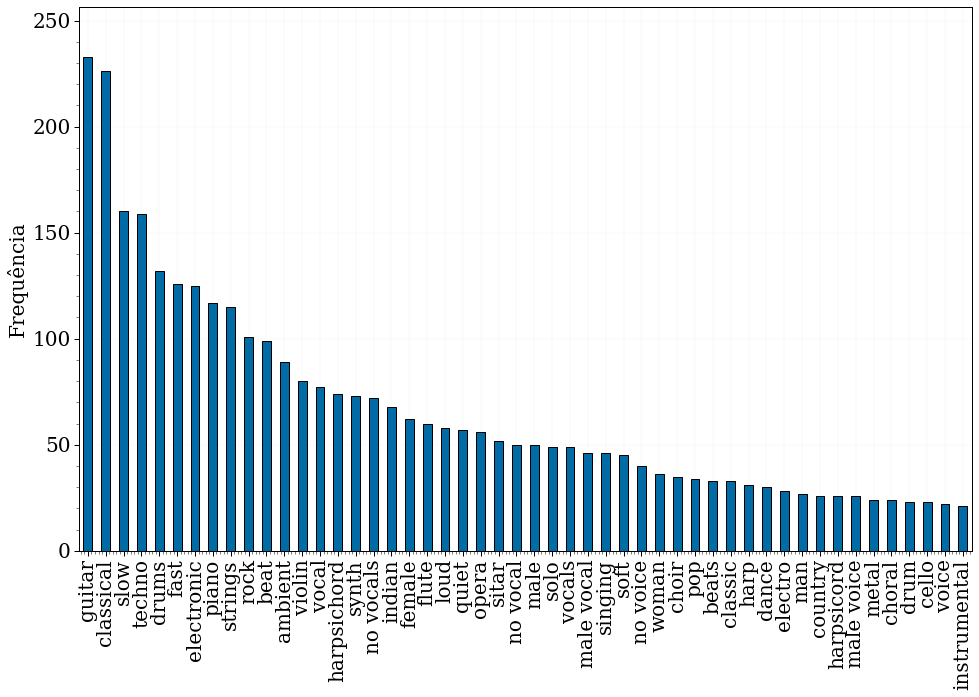

In [7]:
_, ax = plt.subplots(1, 1)
(df.iloc[:, :-1].sum().
 sort_values(ascending=False)[:50].
 plot.bar(ax=ax, rot=90, edgecolor='k')
)
ax.set(ylabel='Frequência')

In [8]:
top = (df.iloc[:, :-1].sum().
       sort_values(ascending=False)[:50]).index
top

Index(['guitar', 'classical', 'slow', 'techno', 'drums', 'fast', 'electronic',
       'piano', 'strings', 'rock', 'beat', 'ambient', 'violin', 'vocal',
       'harpsichord', 'synth', 'no vocals', 'indian', 'female', 'flute',
       'loud', 'quiet', 'opera', 'sitar', 'no vocal', 'male', 'solo', 'vocals',
       'male vocal', 'singing', 'soft', 'no voice', 'woman', 'choir', 'pop',
       'beats', 'classic', 'harp', 'dance', 'electro', 'man', 'country',
       'harpsicord', 'male voice', 'metal', 'choral', 'drum', 'cello', 'voice',
       'instrumental'],
      dtype='object')

In [9]:
df = df[[c for c in top] + ['mp3_path']]
df.shape

(1048, 51)

In [10]:
(df.sum(axis=1) == 0).any()

True

In [11]:
df = df[df.sum(axis=1) != 0]
df = df.sample(frac=1)
df.head()

,guitar,classical,slow,techno,drums,fast,electronic,piano,strings,rock,...,country,harpsicord,male voice,metal,choral,drum,cello,voice,instrumental,mp3_path
clip_id,,,,,,,,,,,,,,,,,,,,,
48082,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,2/jamie_janover-evolutions-12-harbor_island-20...
21149,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1/tim_rayborn-qadim-05-alevlen__saz_turkish-14...
49873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,b/magnatune_compilation-rock-13-emmas_mini_dis...
45656,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,b/richard_savino-mertz__bardic_sounds-11-finga...
8670,1,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,c/william_brooks-blue_ribbon__the_best_of_will...


In [12]:
train_df = df[:768]
val_df = df[768:896]
test_df = df[896:896+128]

print(train_df.shape, val_df.shape, test_df.shape)

(768, 51) (128, 51) (128, 51)


# Training CNNs from Scratch

The baseline code is provided so that you can easily start the homework and also compare with your own algorithm.
The baseline model extracts mel-spectrogram and has a simple set of CNN model that includes convolutional layer, batch normalization, maxpooling and fully-connected layer.

## Data Preprocessing

In [13]:
def to_mel_spectrum(wave, sr=16000, n_fft=516, n_mels=96, secs=6):
    S = librosa.feature.melspectrogram(y=wave[:secs * sr],
                                       sr=sr,
                                       n_fft=n_fft,
                                       n_mels=n_mels)
    S_dB = librosa.power_to_db(S)
    return S_dB

In [14]:
def load_data(file_paths):
    for fpath in file_paths:
        fpath = os.path.join('waveform', fpath)
        yield np.load(fpath)

In [15]:
data_train = list(map(to_mel_spectrum, load_data(train_df['mp3_path'])))
X_train = jnp.array(data_train)
Y_train = jnp.array(train_df.drop('mp3_path', axis=1).values)

data_val = list(map(to_mel_spectrum, load_data(val_df['mp3_path'])))
X_val = jnp.array(data_val)
Y_val = jnp.array(val_df.drop('mp3_path', axis=1).values)

data_test = list(map(to_mel_spectrum, load_data(test_df['mp3_path'])))
X_test = jnp.array(data_test)
Y_test = jnp.array(test_df.drop('mp3_path', axis=1).values)

## Iterating in Batches

In [16]:
batch_size = 16
X_batches = X_train.reshape((X_train.shape[0] // batch_size,
                             batch_size,
                             X_train.shape[1],
                             X_train.shape[2]))
Y_batches = Y_train.reshape((Y_train.shape[0] // batch_size,
                             batch_size,
                             Y_train.shape[1]))

In [17]:
Xb, Yb = X_batches[0], Y_batches[0]
Xb.shape

(16, 96, 188)

In [18]:
Yb.shape

(16, 50)

## Training a baseline
The table below shows the architecture of the baseline.

| Layer          | Output Size | Details                 |
|----------------|-------------|-------------------------|
| input          | B x 1 x 16000 * sec,    | batch x channel x samples |
| mel_spec       | B x 96 x 188    | batch x freq x time|
| conv + maxpool | B x 32 x 64    | kernel_size=3, stride=1 |
| conv + maxpool | B x 32 x 22    | kernel_size=3, stride=1 |
| conv + maxpool | B x 32 x 8     | kernel_size=3 stride=1 |
| global_avgpool | B x 32 x 1     | -                       |
| classifier     | B x 50         | -                       |

The class below is an implementation of it:

In [19]:
class Baseline(nn.Module):
    @nn.compact
    def __call__(self, x):
        for _ in range(3):
            x = nn.Conv(96, kernel_size=(3, ), strides=(1, ))(x)
            x = nn.relu(x)
            x = nn.max_pool(x, window_shape=(3, ), strides=(1, ))
        x = nn.avg_pool(x, window_shape=(1, ))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(50)(x)
        x = nn.log_softmax(x)
        return x

In [20]:
model = Baseline()
variables = model.init(jax.random.PRNGKey(0), jnp.ones(Xb.shape))

In [21]:
logits = Baseline().apply(variables, Xb)
logits.shape

(16, 50)

In [22]:
@jax.jit
def cross_entropy_loss(logits, Yb):
    return -jnp.mean(jnp.sum(Yb * logits, axis=-1))

In [23]:
logits = Baseline().apply(variables, Xb)
cross_entropy_loss(logits, Yb)

DeviceArray(116.08677, dtype=float32)

In [24]:
logits = Baseline().apply(variables, X_train)
cross_entropy_loss(logits, Y_train)

DeviceArray(121.06478, dtype=float32)

In [25]:
logits = Baseline().apply(variables, X_val)
cross_entropy_loss(logits, Y_val)

DeviceArray(120.46097, dtype=float32)

In [26]:
logits = Baseline().apply(variables, X_test)
cross_entropy_loss(logits, Y_test)

DeviceArray(126.45686, dtype=float32)

In [27]:
@jax.jit
def train_step(Xb, Yb, state):
    def loss_fn(params):
        logits = Baseline().apply({'params': params}, Xb)
        loss = cross_entropy_loss(logits, Yb)
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [28]:
from flax.training import train_state

model = Baseline()
variables = model.init(jax.random.PRNGKey(0), jnp.ones(Xb.shape))

lr = 0.0005
iter = 50

params = variables['params']
tx = optax.sgd(learning_rate=lr)
state = train_state.TrainState.create(apply_fn=model.apply,
                                      params=params,
                                      tx=tx)
for i in range(iter):
    for Xb, Yb in zip(X_batches, Y_batches):
        state = train_step(Xb, Yb, state)
    train_loss = cross_entropy_loss(Baseline().apply({'params': state.params},
                                                     X_train),
                                    Y_train)
    val_loss = cross_entropy_loss(Baseline().apply({'params': state.params},
                                                   X_val),
                                  Y_val)
    if i % 10 == 0:
        print('Iter: {}; Train Loss {}; Val Loss = {}'.format(i, train_loss,
                                                              val_loss))

Iter: 0; Train Loss 12.781084060668945; Val Loss = 12.26470947265625
Iter: 10; Train Loss 11.977432250976562; Val Loss = 11.849563598632812
Iter: 20; Train Loss 10.79108715057373; Val Loss = 11.309202194213867
Iter: 30; Train Loss 9.934743881225586; Val Loss = 11.210796356201172
Iter: 40; Train Loss 9.25684928894043; Val Loss = 11.320720672607422


In [41]:
def auto_tagging(id, df, X, model, params, topk):
    row = df.iloc[id].copy()
    audio_sample = [row['mp3_path']]
    row = row.drop('mp3_path')
    wave = next(load_data(audio_sample))

    X = jnp.array([X[id]])
    logit = model().apply({'params': params}, X)[0]
    idx = logit.argsort()[-topk:][::-1]
    
    # Converter de devicearray (JAX) para numpy, senão dá erro
    idx = np.array(idx)
    
    return wave, row[idx].index

In [42]:
import IPython.display as ipd

id = 30
wave, tags = auto_tagging(id, test_df, X_test, Baseline, state.params, 5)
print(tags)
ipd.Audio(wave, rate=16000) # load a NumPy array

Index(['techno', 'fast', 'guitar', 'male vocal', 'drums'], dtype='object')


### [Question 1] Implement the given architecture.
Implement a 2D CNN with the architecture below, train, and report a test accuracy of the 2D CNN.

| Layer          | Output Size | Details                 |
|----------------|-------------|-------------------------|
| input          | B x 1 x sample_rate * duration,    | batch x channel (mono) x samples |
| mel_spec       | B x 1 x 96 x 188    | batch x channel (mono) x freq x time|
| conv + maxpool | B x 64 x 24 x 47    | output_channels=64, kernel_size=3, pooling=(4,4) |
| conv + maxpool | B x 128 x 8 x 15    | output_channels=128, kernel_size=3, pooling=(3,3) |
| conv + maxpool | B x 128 x  2 x 5     | output_channels=128, kernel_size=3 pooling=(3,3) |
| conv + maxpool | B x 64 x 1 x 1      | output_channels=64, kernel_size=3 pooling=(2,5)                    |
| classifier     | B x 50         | -                       |


Note: you should give appropriate paddings! 

#### Canal Mono

O Jax só entende se a dimensão em que os canais ficam for a última, por isso o $1$ indicando o canal mono foi adicionado ao final.

In [359]:
# Reshape to include channel
batch_size = 16
X_batches = X_train.reshape((X_train.shape[0] // batch_size,
                             batch_size,
                             X_train.shape[1],
                             X_train.shape[2],
                             1))
Y_batches = Y_train.reshape((Y_train.shape[0] // batch_size,
                             batch_size,
                             Y_train.shape[1]))

In [360]:
Xb, Yb = X_batches[0], Y_batches[0]
Xb.shape

(16, 96, 188, 1)

Temos que adicionar essa dimensão no treino e no teste para podermos usá-los posteriormente também.

In [386]:
Xc_train = X_train.reshape((X_train.shape[0],
                            X_train.shape[1],
                            X_train.shape[2],
                            1))
Xc_test = X_test.reshape((X_test.shape[0],
                          X_test.shape[1],
                          X_test.shape[2],
                          1))
Xc_val = X_val.reshape((X_val.shape[0],
                        X_val.shape[1],
                        X_val.shape[2],
                        1))
Xc_train.shape, Xc_test.shape, Xc_val.shape

((768, 96, 188, 1), (128, 96, 188, 1), (128, 96, 188, 1))

#### Construção (Manual) da Rede

Primeiro, é necessário implementar manualmente para conferir o tamanho das saídas e as necessidades de paddings eventuais. Para auxiliar no cálculo das entradas e saídas das camadas convolucionais, usamos uma ferramenta online: https://madebyollin.github.io/convnet-calculator/.

In [335]:
# Initialization
# Layer 1
in1_data = jax.random.uniform(seed,(16, 96, 188, 1))
in1_data_p = jnp.pad(in1_data, [(0,0),(6,6),(6,6),(0,0)], mode='constant')
conv_layer1 = nn.Conv(features=64, kernel_size=(3,3),padding="SAME", strides=(4,4), name="CONV1")

# Layer 2
in2_data = jax.random.uniform(seed,(16, 24, 47, 64))
in2_data_p = jnp.pad(in2_data, [(0,0),(3,3),(1,1),(0,0)], mode='constant')
conv_layer2 = nn.Conv(features=128, kernel_size=(3,3),padding="SAME", strides=(3,3), name="CONV2")

# Layer 3
in3_data = jax.random.uniform(seed,(16, 8, 15, 128))
in3_data_p = jnp.pad(in3_data, [(0,0),(1,1),(3,3),(0,0)], mode='constant')
conv_layer3 = nn.Conv(features=128, kernel_size=(3,3),padding="SAME", strides=(3,3), name="CONV3")

# Layer 4
in4_data = jax.random.uniform(seed,(16, 2, 5, 128))
in4_data_p = jnp.pad(in4_data, [(0,0),(0,0),(0,0),(0,0)], mode='constant')
conv_layer4 = nn.Conv(features=64, kernel_size=(3,3),padding="SAME", name="CONV4")


# Dense Layer
in5_data = jax.random.uniform(seed,(16, 1, 1, 64))
in5_data_p = in5_data.reshape((in5_data.shape[0], -1))  # flatten
dense = nn.Dense(50)
#         x = nn.log_softmax(x)

# Init layers
params1 = conv_layer1.init(seed, in1_data_p)
params2 = conv_layer2.init(seed, in2_data_p)
params3 = conv_layer3.init(seed, in3_data_p)
params4 = conv_layer4.init(seed, in4_data_p)
params5 = dense.init(seed, in5_data_p)

In [338]:
# Applying
# Layer 1
preds1 = conv_layer1.apply(params1, in1_data_p)
preds2 = nn.max_pool(nn.relu(preds1), window_shape=(4,4))

# Layer 2
preds3 = conv_layer2.apply(params2, in2_data_p)
preds4 = nn.max_pool(nn.relu(preds3), window_shape=(3,3))

# Layer 3
preds5 = conv_layer3.apply(params3, in3_data_p)
preds6 = nn.max_pool(nn.relu(preds5), window_shape=(3,3))

# Layer 4
preds7 = conv_layer4.apply(params4, in4_data_p)
preds8 = nn.max_pool(nn.relu(preds7), window_shape=(2,5))

# Dense
preds9 = dense.apply(params5, in5_data_p)
preds10 = nn.log_softmax(preds9)

Assim, podemos garantir que o formato dos dados entre cada layer entre cada estão corretos.

In [340]:
# Verifying shapes
print("\nInput Shape               : {}".format((16, 96, 188, 1)))
print("Conv Layer 1 Output Shape : {}".format(preds1.shape))
print("MaxPool Layer 1 Output Shape : {}".format(preds2.shape))
print("Conv Layer 2 Output Shape : {}".format(preds3.shape))
print("MaxPool Layer 2 Output Shape : {}".format(preds4.shape))
print("Conv Layer 3 Output Shape : {}".format(preds5.shape))
print("MaxPool Layer 3 Output Shape : {}".format(preds6.shape))
print("Conv Layer 4 Output Shape : {}".format(preds7.shape))
print("MaxPool Layer 4 Output Shape : {}".format(preds8.shape))
print("Dense Output Shape : {}".format(preds9.shape))
print("Log Softmax Output Shape : {}".format(preds10.shape))


Input Shape               : (16, 96, 188, 1)
Conv Layer 1 Output Shape : (16, 27, 50, 64)
MaxPool Layer 1 Output Shape : (16, 24, 47, 64)
Conv Layer 2 Output Shape : (16, 10, 17, 128)
MaxPool Layer 2 Output Shape : (16, 8, 15, 128)
Conv Layer 3 Output Shape : (16, 4, 7, 128)
MaxPool Layer 3 Output Shape : (16, 2, 5, 128)
Conv Layer 4 Output Shape : (16, 2, 5, 64)
MaxPool Layer 4 Output Shape : (16, 1, 1, 64)
Dense Output Shape : (16, 50)
Log Softmax Output Shape : (16, 50)


#### Implementação

In [396]:
class Baseline_q1(nn.Module):
    def setup(self):
        self.conv1 = nn.Conv(features=64, kernel_size=(3,3),padding="SAME", strides=(4,4), name="CONV1")
        self.conv2 = nn.Conv(features=128, kernel_size=(3,3),padding="SAME", strides=(3,3), name="CONV2")
        self.conv3 = nn.Conv(features=128, kernel_size=(3,3),padding="SAME", strides=(3,3), name="CONV3")
        self.conv4 = nn.Conv(features=64, kernel_size=(3,3),padding="SAME", name="CONV4")
        self.dense = nn.Dense(50, name="DENSE")
    
    @nn.compact
    def __call__(self, in_data):
        # Input
        x = in_data
        
        # Layer 1
        x = jnp.pad(x, [(0,0),(6,6),(6,6),(0,0)], mode='constant')
        x = self.conv1(x)
        x = nn.max_pool(nn.relu(x), window_shape=(4,4))
        
        # Layer 2
        x = jnp.pad(x, [(0,0),(3,3),(1,1),(0,0)], mode='constant')
        x = self.conv2(x)
        x = nn.max_pool(nn.relu(x), window_shape=(3,3))
        
        # Layer 3
        x = jnp.pad(x, [(0,0),(1,1),(3,3),(0,0)], mode='constant')
        x = self.conv3(x)
        x = nn.max_pool(nn.relu(x), window_shape=(3,3))
        
        # Layer 4
        x = jnp.pad(x, [(0,0),(0,0),(0,0),(0,0)], mode='constant')
        x = self.conv4(x)
        x = nn.max_pool(nn.relu(x), window_shape=(2,5))
        
        # Dense
        x = x.reshape((x.shape[0], -1))  # flatten
        x = self.dense(x)
        x = nn.log_softmax(x)
        
        # Output
        return x

In [365]:
@jax.jit
def cross_entropy_loss(logits, Yb):
    return -jnp.mean(jnp.sum(Yb * logits, axis=-1))

In [406]:
# Cross-entropy for some sets
model = Baseline_q1()
variables = model.init(jax.random.PRNGKey(0), jnp.ones(Xb.shape))

pairs = [
    (Xb, Yb),
    (Xc_train, Y_train),
    (Xc_val, Y_val),
    (Xc_test, Y_test)
]

for x,y in pairs:
    logits = Baseline_q1().apply(variables, x)
    print(cross_entropy_loss(logits, y))

164.9949
164.46002
158.99342
158.27249


In [390]:
@jax.jit
def train_step(Xb, Yb, state):
    def loss_fn(params):
        logits = Baseline_q1().apply({'params': params}, Xb)
        loss = cross_entropy_loss(logits, Yb)
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [411]:
from flax.training import train_state

# Model initialization
model = Baseline_q1()
variables = model.init(jax.random.PRNGKey(0), jnp.ones(Xb.shape))


# Training Setup
lr = 0.0005    # learning rate
iter = 50      # max iterations
params = variables['params']
tx = optax.sgd(learning_rate=lr)
state = train_state.TrainState.create(apply_fn=model.apply,
                                      params=params,
                                      tx=tx)
# Training
for i in range(iter):
    for Xb, Yb in zip(X_batches, Y_batches):
        state = train_step(Xb, Yb, state)
    train_loss = cross_entropy_loss(Baseline_q1().apply({'params': state.params},
                                                     Xc_train),
                                    Y_train)
    val_loss = cross_entropy_loss(Baseline_q1().apply({'params': state.params},
                                                   Xc_val),
                                  Y_val)
    if i % 10 == 0:
        print('Iter: {}; Train Loss {}; Val Loss = {}'.format(i, train_loss,
                                                              val_loss))

Iter: 0; Train Loss 12.62722396850586; Val Loss = 12.070493698120117
Iter: 10; Train Loss 11.26512336730957; Val Loss = 11.002967834472656
Iter: 20; Train Loss 10.768661499023438; Val Loss = 10.794830322265625
Iter: 30; Train Loss 10.32654857635498; Val Loss = 10.636934280395508
Iter: 40; Train Loss 9.942453384399414; Val Loss = 10.549888610839844


In [408]:
id = 30
wave, tags = auto_tagging(id, test_df, Xc_test, Baseline_q1, state.params, 5)
print(tags)
ipd.Audio(wave, rate=16000) # load a NumPy array

Index(['techno', 'drums', 'electronic', 'slow', 'fast'], dtype='object')


### [Question 2] Improve the performenace.
Now it is your turn. You should improve the baseline code with your own algorithm. There are many ways to improve it. The followings are possible ideas: 

* You can try 1D CNN or 2D CNN models and choose different model parameters:
    * Filter size
    * Pooling size
    * Stride size 
    * Number of filters
    * Model depth
    * Regularization: L2/L1 and Dropout

* You should try different hyperparameters to train the model and optimizers:
    * Learning rate
    * Model depth
    * Optimizers: SGD (with Nesterov momentum), Adam, RMSProp, ...

* You can try training a model using both mel-spectrograms and features extracted using the pre-trained models. However, end-to-end training using additional external data is prohibited. (Performance doesn't have a huge impact on grading. don't waste time)


* You can try different parameters (e.g. hop and window size) to extract mel-spectrogram or different features as input to the network (e.g. MFCC, chroma features ...). 

* You can also use ResNet or other CNNs with skip connections. 

* Furthermore, you can augment data using digital audio effects.

* Tentativa 1: Optimizer Adam. Mesma learning rate, mais iterações.

In [419]:
from flax.training import train_state

# Model initialization
model = Baseline_q1()
variables = model.init(jax.random.PRNGKey(0), jnp.ones(Xb.shape))


# Training Setup
lr = 0.0001    # learning rate
iter = 100      # max iterations
params = variables['params']
tx = optax.adam(learning_rate=lr)
state = train_state.TrainState.create(apply_fn=model.apply,
                                      params=params,
                                      tx=tx)
# Training
for i in range(iter):
    for Xb, Yb in zip(X_batches, Y_batches):
        state = train_step(Xb, Yb, state)
    train_loss = cross_entropy_loss(Baseline_q1().apply({'params': state.params},
                                                     Xc_train),
                                    Y_train)
    val_loss = cross_entropy_loss(Baseline_q1().apply({'params': state.params},
                                                   Xc_val),
                                  Y_val)
    if i % 10 == 0:
        print('Iter: {}; Train Loss {}; Val Loss = {}'.format(i, train_loss,
                                                              val_loss))

Iter: 0; Train Loss 14.60505485534668; Val Loss = 14.605110168457031
Iter: 10; Train Loss 10.594858169555664; Val Loss = 11.201753616333008
Iter: 20; Train Loss 9.445243835449219; Val Loss = 10.983927726745605
Iter: 30; Train Loss 8.523658752441406; Val Loss = 11.123468399047852
Iter: 40; Train Loss 8.015274047851562; Val Loss = 11.514968872070312
Iter: 50; Train Loss 7.8106489181518555; Val Loss = 12.167739868164062
Iter: 60; Train Loss 7.4864325523376465; Val Loss = 12.37695598602295
Iter: 70; Train Loss 6.904102325439453; Val Loss = 12.046272277832031
Iter: 80; Train Loss 6.757500648498535; Val Loss = 12.361353874206543
Iter: 90; Train Loss 6.635414123535156; Val Loss = 12.786493301391602


Melhorou no o desempenho treino, mas não na validação.

* Tentativa 2: Optimizer RMSProp. Mesmas condições de acima.

In [420]:
from flax.training import train_state

# Model initialization
model = Baseline_q1()
variables = model.init(jax.random.PRNGKey(0), jnp.ones(Xb.shape))


# Training Setup
lr = 0.0001    # learning rate
iter = 100      # max iterations
params = variables['params']
tx = optax.rmsprop(learning_rate=lr)
state = train_state.TrainState.create(apply_fn=model.apply,
                                      params=params,
                                      tx=tx)
# Training
for i in range(iter):
    for Xb, Yb in zip(X_batches, Y_batches):
        state = train_step(Xb, Yb, state)
    train_loss = cross_entropy_loss(Baseline_q1().apply({'params': state.params},
                                                     Xc_train),
                                    Y_train)
    val_loss = cross_entropy_loss(Baseline_q1().apply({'params': state.params},
                                                   Xc_val),
                                  Y_val)
    if i % 10 == 0:
        print('Iter: {}; Train Loss {}; Val Loss = {}'.format(i, train_loss,
                                                              val_loss))

Iter: 0; Train Loss 16.59552001953125; Val Loss = 16.31749725341797
Iter: 10; Train Loss 10.404112815856934; Val Loss = 10.998631477355957
Iter: 20; Train Loss 9.525312423706055; Val Loss = 11.143600463867188
Iter: 30; Train Loss 8.917200088500977; Val Loss = 11.442054748535156
Iter: 40; Train Loss 8.727582931518555; Val Loss = 12.195152282714844
Iter: 50; Train Loss 8.166852951049805; Val Loss = 12.513562202453613
Iter: 60; Train Loss 6.789891719818115; Val Loss = 11.966190338134766
Iter: 70; Train Loss 6.634889125823975; Val Loss = 12.28812313079834
Iter: 80; Train Loss 6.4731292724609375; Val Loss = 12.523033142089844
Iter: 90; Train Loss 6.517834663391113; Val Loss = 12.860443115234375


* Tentativa 3: regularização L2 (para tentar controlar o overfitting)

In [428]:
@jax.jit
def cross_entropy_loss_l2(logits, Yb):
    @jax.jit
    def l2_loss(x, alpha):
        return alpha * (x ** 2).mean()
    
    loss = -jnp.mean(jnp.sum(Yb * logits, axis=-1))
    loss += sum(
        l2_loss(w, alpha=0.001)
        for w in jax.tree_leaves(variables["params"])
    )
    return -jnp.mean(jnp.sum(Yb * logits, axis=-1))

In [429]:
from flax.training import train_state

# Model initialization
model = Baseline_q1()
variables = model.init(jax.random.PRNGKey(0), jnp.ones(Xb.shape))


# Training Setup
lr = 0.0001    # learning rate
iter = 100      # max iterations
params = variables['params']
tx = optax.rmsprop(learning_rate=lr)
state = train_state.TrainState.create(apply_fn=model.apply,
                                      params=params,
                                      tx=tx)
# Training
for i in range(iter):
    for Xb, Yb in zip(X_batches, Y_batches):
        state = train_step(Xb, Yb, state)
    train_loss = cross_entropy_loss_l2(Baseline_q1().apply({'params': state.params},
                                                     Xc_train),
                                    Y_train)
    val_loss = cross_entropy_loss_l2(Baseline_q1().apply({'params': state.params},
                                                   Xc_val),
                                  Y_val)
    if i % 10 == 0:
        print('Iter: {}; Train Loss {}; Val Loss = {}'.format(i, train_loss,
                                                              val_loss))

Iter: 0; Train Loss 14.867919921875; Val Loss = 14.65875244140625
Iter: 10; Train Loss 10.519182205200195; Val Loss = 11.273033142089844
Iter: 20; Train Loss 9.319395065307617; Val Loss = 11.073441505432129
Iter: 30; Train Loss 8.449694633483887; Val Loss = 11.236534118652344
Iter: 40; Train Loss 8.026228904724121; Val Loss = 11.830467224121094
Iter: 50; Train Loss 7.110755920410156; Val Loss = 11.67819595336914
Iter: 60; Train Loss 6.849591255187988; Val Loss = 11.78262996673584
Iter: 70; Train Loss 6.577359676361084; Val Loss = 12.190184593200684
Iter: 80; Train Loss 7.197256088256836; Val Loss = 13.190620422363281
Iter: 90; Train Loss 6.40088415145874; Val Loss = 12.628320693969727


### [Question 3] Improve the performance.
Now it is your turn. You should improve the baseline code with your own algorithm. There are many ways to improve it. The followings are possible ideas: 

* Change backbone model
  - https://arxiv.org/abs/1711.02520
  - https://arxiv.org/abs/2006.00751